# Target Selection

In [40]:
# data manipulation libraries
import pandas as pd
import numpy as np

# custom project libraries
from utils.wine_review_utils import load_augmented_data, RATINGS

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Load Augmented data

In [41]:
# focus on most reviewed variety from most reviewed country to accelerate the feature selection process
reviews = load_augmented_data()
pinot = reviews.query('variety == "Pinot Noir" and country == "US"') 
pinot.info()
pinot.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8886 entries, 4 to 129967
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   winery              8886 non-null   object 
 1   variety             8886 non-null   object 
 2   year                8886 non-null   int64  
 3   country             8886 non-null   object 
 4   price               8860 non-null   float64
 5   taster_name         8886 non-null   object 
 6   description         8886 non-null   object 
 7   points              8886 non-null   int64  
 8   rating              8886 non-null   object 
 9   description_length  8886 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 763.6+ KB


,winery,variety,year,country,price,taster_name,description,points,rating,description_length
4,Sweet Cheeks,Pinot Noir,2012,US,65.0,Paul Gregutt,"Much like the regular bottling from 2012, this...",87,very good,249
21,Acrobat,Pinot Noir,2013,US,20.0,Paul Gregutt,"A sleek mix of tart berry, stem and herb, alon...",87,very good,233
25,Castello di Amorosa,Pinot Noir,2011,US,69.0,Virginie Boone,Oak and earth intermingle around robust aromas...,87,very good,259
35,Erath,Pinot Noir,2010,US,50.0,Paul Gregutt,As with many of the Erath 2010 vineyard design...,86,good,242
78,Z'IVO,Pinot Noir,2015,US,25.0,Paul Gregutt,Some rosés are made simply by bleeding the jui...,86,good,288


**Feature and Target**

In [42]:
X = pinot.description.to_frame()
Y = pinot[['points', 'rating']]

In [43]:
X.head()

,description
4,"Much like the regular bottling from 2012, this..."
21,"A sleek mix of tart berry, stem and herb, alon..."
25,Oak and earth intermingle around robust aromas...
35,As with many of the Erath 2010 vineyard design...
78,Some rosés are made simply by bleeding the jui...


In [44]:
Y.head()

,points,rating
4,87,very good
21,87,very good
25,87,very good
35,86,good
78,86,good


## Feature Engineering Transformers

**Length Transformer**

In [45]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def to_len(series):
    return np.array([[len(el)] for el in series.to_list()])
    

# to_len = lambda series: np.array([series.str.len()])
to_features_out = lambda self, cols: cols + '_length'

len_transformer_builder = lambda: ColumnTransformer([('len', FunctionTransformer(to_len, feature_names_out=to_features_out), 'description')])

len_transformer = len_transformer_builder()
len_transformer

ColumnTransformer(transformers=[('len',
                                 FunctionTransformer(feature_names_out=<function <lambda> at 0x4b856f920>,
                                                     func=<function to_len at 0x4b856f420>),
                                 'description')])

In [46]:
# inspect the length transformer
len_transformer.fit_transform(X.head()), len_transformer.get_feature_names_out()

(array([[249],
        [233],
        [259],
        [242],
        [288]]),
 array(['len__description_length'], dtype=object))

**TF-IDF Vectorizer** 

In [47]:
import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

swords = stopwords.words('english') + ['year', 'years', 'wine', 'wines', 'country', 'variety']

tfidf_transformer_builder = lambda: ColumnTransformer([('tfidf', TfidfVectorizer(stop_words=swords, min_df=.015, max_df=.95, token_pattern=r'\b[^\d\W]+\b'), 'description')])

tfidf_transformer = tfidf_transformer_builder()
tfidf_transformer


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ColumnTransformer(transformers=[('tfidf',
                                 TfidfVectorizer(max_df=0.95, min_df=0.015,
                                                 stop_words=['a', 'about',
                                                             'above', 'after',
                                                             'again', 'against',
                                                             'ain', 'all', 'am',
                                                             'an', 'and', 'any',
                                                             'are', 'aren',
                                                             "aren't", 'as',
                                                             'at', 'be',
                                                             'because', 'been',
                                                             'before', 'being',
                                                             'below', 'between',
                                                             'both', 'but',
                                                             'by', 'can',
                                                             'couldn',
                                                             "couldn't", ...],
                                                 token_pattern='\\b[^\\d\\W]+\\b'),
                                 'description')])

In [48]:
# inspect the TF-IDF transformer
tfidf_transformer.fit_transform(X.head()), tfidf_transformer.get_feature_names_out()[:5]

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 120 stored elements and shape (5, 113)>,
 array(['tfidf__across', 'tfidf__aged', 'tfidf__along', 'tfidf__aromas',
        'tfidf__around'], dtype=object))

**Sentence Embedding Transformer**

In [49]:
from sklearn.preprocessing import FunctionTransformer
from sentence_transformers import SentenceTransformer
from sklearn.compose import ColumnTransformer

model = SentenceTransformer('all-mpnet-base-v2')
to_embeddings = lambda series: model.encode(series.to_list(), normalize_embeddings=False, show_progress_bar=True, device='mps')

to_features_out = lambda self, cols: [f'{i}' for i in range(768)]

embeddings_transformer_builder = lambda: ColumnTransformer([('encode', FunctionTransformer(to_embeddings, feature_names_out=to_features_out), 'description')])

embeddings_transformer = embeddings_transformer_builder()
embeddings_transformer

ColumnTransformer(transformers=[('encode',
                                 FunctionTransformer(feature_names_out=<function <lambda> at 0x39d5de5c0>,
                                                     func=<function <lambda> at 0x39d828cc0>),
                                 'description')])

In [50]:
# inspect the Sentence Embeddings transformer
embeddings_transformer.fit_transform(X.head()), embeddings_transformer.get_feature_names_out()[:5]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(array([[ 0.01135205,  0.05722262, -0.02329289, ...,  0.0213642 ,
          0.02545355, -0.02229968],
        [ 0.02861682, -0.01286418, -0.01699221, ...,  0.0097644 ,
          0.01887408,  0.00159719],
        [ 0.00784886,  0.01356204, -0.02390206, ..., -0.00452181,
          0.03659626,  0.00372298],
        [ 0.0438433 ,  0.04319904, -0.01900682, ...,  0.00879501,
         -0.01659967, -0.05413132],
        [ 0.0479098 ,  0.01303082, -0.00465869, ..., -0.01533878,
          0.0656874 , -0.00180852]], dtype=float32),
 array(['encode__0', 'encode__1', 'encode__2', 'encode__3', 'encode__4'],
       dtype=object))

## Evaluate Feature Engineering Transformers

**Training Helpers**

In [51]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, hamming_loss, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def validation_metrics(estimator, X_val, y_val, df = pinot, target='points'):
  """
  function return summary of evaluation for the model 
  """
  y_preds = estimator.predict(X_val)
  y_preds_proba = estimator.predict_proba(X_val)

  # change evaluation methods if needed
  average = 'macro'
  accuracy = accuracy_score(y_val, y_preds)
  f1 = f1_score(y_val, y_preds, average=average, zero_division=0)
  hammer_loss= hamming_loss(y_val, y_preds)
  precision = precision_score(y_val, y_preds, average=average, zero_division=0)
  recall = recall_score(y_val, y_preds, average=average, zero_division=0)
  # roc_auc = roc_auc_score(y_val, y_preds_proba, average='weighted',multi_class='ovr')
  class_report = classification_report(y_val, y_preds, zero_division=0)

  # confusion matrix
  conf_matrix = confusion_matrix(y_val, y_preds, normalize='pred') #, labels=np.unique(df[target]))

  df = pd.DataFrame({'accuracy': accuracy,
                     'f1': f1,
                     'hammer_loss': hammer_loss,
                     'precision': precision,
                     'recall': recall,
                    #  'roc_auc': roc_auc
                     }, 
                    index=[estimator.__class__.__name__])
  
  return {
      'detail': df,
      'conf_matrix': conf_matrix,
      'summary': class_report,
      'predictions': y_preds,
      'pred_proba': y_preds_proba
  }

In [52]:
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# helper that evaluates the feature engineering transformer and target used
def train_pipeline(estimator, X, y):
  # training/test data split
  le = LabelEncoder()
  X_train, X_test, y_train, y_test = train_test_split(X,le.fit_transform(y), test_size=0.2, random_state=42, stratify=y)
  # train the classifier
  start = time.perf_counter()
  estimator.fit(X_train, y_train)
  duration = time.perf_counter() - start
  # evaluate the performance of the classifier
  metrics_train = validation_metrics(estimator, X_train, y_train)
  metrics_test = validation_metrics(estimator, X_test, y_test)
  return duration, metrics_train, metrics_test

**Training Pipelines**

In [53]:
from sklearn.ensemble import RandomForestClassifier

# given a feature engineering scheme, creating a classifier training pipeline using LogisticRegression as the classifier
pipeline_builder = lambda transformer_builder: Pipeline([('preprocess', transformer_builder()), ('lr', RandomForestClassifier(max_depth=5, random_state=42))])

pipelines = [
  # description length
  ('review length', pipeline_builder(len_transformer_builder)),
  # TF-IDF vectorizer
  ('tf-idf', pipeline_builder(tfidf_transformer_builder)),
  # sentence embeddings
  ('embeddings', pipeline_builder(embeddings_transformer_builder)),
]

targets = ['points', 'rating']

### Evaluate Performance of Pipelines

In [54]:
perf_results = [(label, target, train_pipeline(estimator, X, Y[target])) for label, estimator in pipelines for target in targets]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

In [55]:
# view summary of results
pd.DataFrame([(result[0], result[1], result[2][1]['detail'].accuracy[0], result[2][2]['detail'].accuracy[0]) for result in perf_results], 
             columns=['feature', 'target', 'accuracy_train', 'accuracy_test'])

/var/folders/1n/w7vnl41d04bd7_gnq8m6x3l40000gn/T/ipykernel_28518/3029590602.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pd.DataFrame([(result[0], result[1], result[2][1]['detail'].accuracy[0], result[2][2]['detail'].accuracy[0]) for result in perf_results],


,feature,target,accuracy_train,accuracy_test
0,review length,points,0.220034,0.186164
1,review length,rating,0.563168,0.546119
2,tf-idf,points,0.231992,0.167042
3,tf-idf,rating,0.512099,0.505062
4,embeddings,points,0.330332,0.172103
5,embeddings,rating,0.562606,0.512373


In [56]:
def plot_conf_matrix(conf_matrix, title, df = pinot, target='points'):
  """
  Plot confusion matrix
  """
  fig = plt.figure(figsize=(7.5,4))
  sns.heatmap(conf_matrix, 
              xticklabels=np.unique(df[target]), yticklabels=np.unique(df[target]),
              annot=True, 
              cmap="Purples", 
              fmt=".2f", 
              annot_kws={"size": 7.5})
  plt.xlabel('Predictions', fontsize=10)
  plt.ylabel('True lables', fontsize=10)
  plt.xticks(rotation=0, fontsize=9)
  plt.yticks(rotation=0, fontsize=9)
  plt.title(title)
  plt.tight_layout()  
  plt.show()


### Comparing Confusion Matrix for `points` Target

**Review Length Feature**

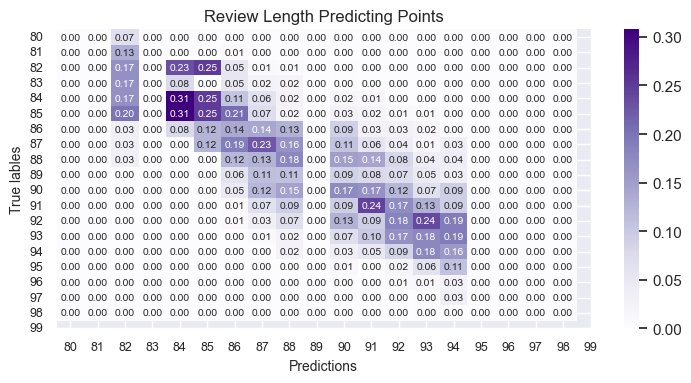

In [57]:
conf_matrix = perf_results[0][2][2]['conf_matrix']
plot_conf_matrix(conf_matrix, 'Review Length Predicting Points')

**TF-IDF Feature**

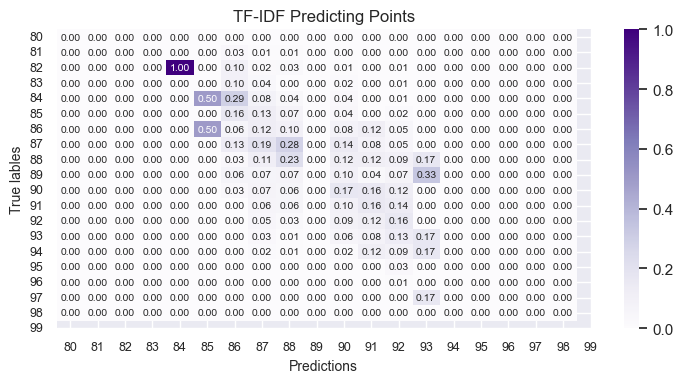

In [58]:
conf_matrix = perf_results[2][2][2]['conf_matrix']
plot_conf_matrix(conf_matrix, 'TF-IDF Predicting Points')

**Sentence Embeddings Feature**

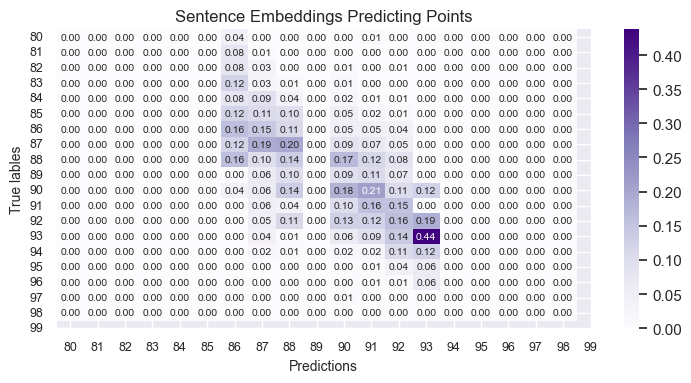

In [59]:
conf_matrix = perf_results[4][2][2]['conf_matrix']
plot_conf_matrix(conf_matrix, 'Sentence Embeddings Predicting Points')

### Comparing Confusion Matrix for `rating` Target

**Review Length Feature**

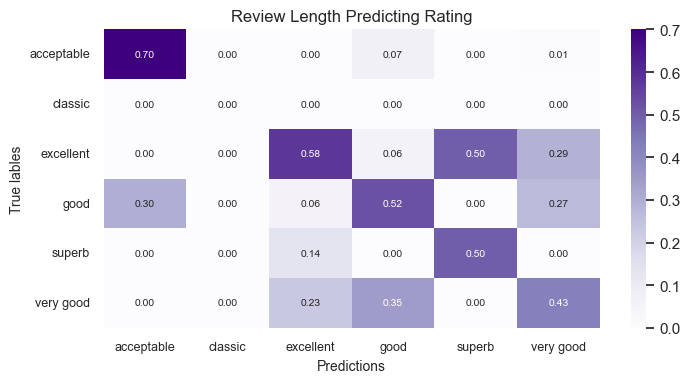

In [60]:
conf_matrix = perf_results[1][2][2]['conf_matrix']
plot_conf_matrix(conf_matrix, 'Review Length Predicting Rating', target='rating')

**TF-IDF Feature**

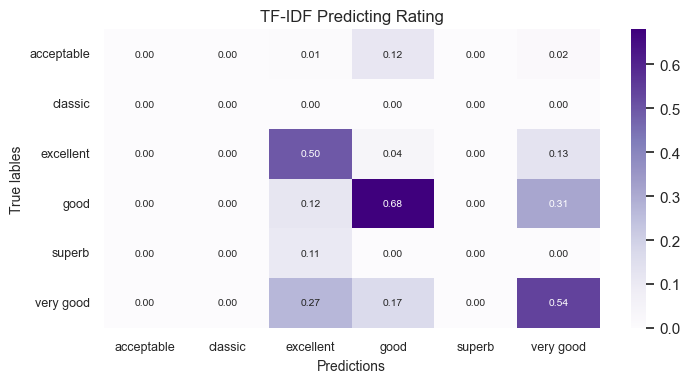

In [61]:
conf_matrix = perf_results[3][2][2]['conf_matrix']
plot_conf_matrix(conf_matrix, 'TF-IDF Predicting Rating', target='rating')

**Sentence Embeddings Feature**

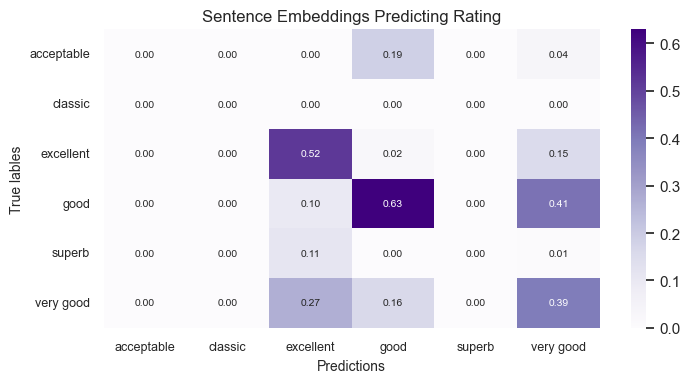

In [62]:
conf_matrix = perf_results[5][2][2]['conf_matrix']
plot_conf_matrix(conf_matrix, 'Sentence Embeddings Predicting Rating', target='rating')

## Conclusion

- Sentence Embeddings appear to perform better then TF-IDF. Review length covers that range of targets better. As a result, both result length and embeddings will be used as features.
- There is a lot of confusion near the diagonal when the target is `points`. The description may be too terse for the models to properly distinguish when there are that many categories. As a result the target will be `rating`.

## Next
 - [Model Training](model-training.ipynb)